# Chapter 6 학습 관련 기술들

딥러닝 학습 효율, 정확도 개선 방법
- 가중치 매개변수 최적값 탐색하는 최적화 방법
- 가중치 매개변수 초깃값
- 하이퍼파라미터 설정 방법
- 오버피팅 대응책
    - 가중치 감소
    - 드롭아웃
- 배치 정규화

## 6.1 매개변수 갱신

신경망 학습의 목표는 매개변수의 최적값을 찾는 **최적화(optimization)**이다. 여태까지 사용한 최적화 방법으로 미분을 이용했는데 이 방법을 **확률적 경사 하강법(SGD)**라고 한다.

### 6.1.1 모험가 이야기 (생략)

### 6.1.2 확률적 경사 하강법(SGD)

- SGD 수식

$$W \leftarrow W - \eta \frac {\partial L} {\partial W}$$

In [1]:
class SGD:
    
    def __init__(self, lr=0.01):
        self.lr = lr
        
    
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

다음은 SGD 클래스를 사용하는 의사코드 예시이다.

```
network = TwoLayerNet(...)
optimizer = SGD()

for i in range(10000):
    ...
    x_batch, t_batch = get_mini_batch(...)
    grads = network.gradient(x_batch, t_batch)
    params = network.params
    optimizer.update(params, grads)
    ...
```

매개 변수 갱신은 optimizer가 책임을 지고 optimizer에 매개변수와 기울기 정보만 넘겨주면 된다. 여러 최적화 관련 클래스를 만들어 모듈화하면 다양한 방법으로 쉽게 최적화할 수 있다.

### 6.1.3 SGD의 단점

- 예시 함수

$$f(x, y) = \frac 1 {20} x^2 + y^2$$

<img src="https://mblogthumb-phinf.pstatic.net/MjAxNzA3MjdfMjU3/MDAxNTAxMTIxODU0MTYx.RZxiBW4kDiXReqK1UDxfBAffbM-pWJQwEI82m-evhucg.N_UhoBOXaCVYUPsP4wuoi4UUL1qQ_5iNEB000_QP1S4g.PNG.cjswo9207/fig_6-1.png?type=w2">
<center><small>▲ 그래프(왼쪽), 등고선(오른쪽)</small></center>

<img src="https://mblogthumb-phinf.pstatic.net/MjAxNzA3MjdfMTMx/MDAxNTAxMTIxOTIwOTE4.b5qnZS_a5u0UOQV16EQzWZpGXpmAkjKeqNVE8COqaNQg.sO1Li2aqIyVhpv3h1NfwLCuyqUfw9G1GZR-Nbsy0trgg.PNG.cjswo9207/fig_6-2.png?type=w2">
<center><small>▲ 기울기</small></center>

최솟값이 되는 위치는 $(x, y) = (0, 0)$이지만 대부분의 기울기는 $(0, 0)$을 가리키지 않는다.

<img src="https://mblogthumb-phinf.pstatic.net/MjAxNzA3MjdfMTU0/MDAxNTAxMTIyMDAwNTA1.E7zIAUXugKPAA5WiBXpF7HtATQ8nVjfBvJF-LJwqtsIg.52gqDjo2sPPup4Bfz5hOtp_b1svFcFItoYAJreHPp6Ag.PNG.cjswo9207/fig_6-3.png?type=w2">
<center><small>▲ SGD에 의한 최적화  갱신 경로</small></center>

- 비등방성 함수(방향에 따라 기울기가 달라지는 함수)에서 탐색 경로가 비효율적
- 근본 원인은 최솟값과 다른 방향을 가리키는 기울기

### 6.1.4 모멘텀(Momentum)

$$\mathbf{v} \leftarrow \alpha \mathbf{v} - \eta \frac {\partial L} {\partial W}$$
$$W \leftarrow W + \mathbf{v}$$

- $\mathbf{v}$: 속도
- 위의 첫번째 식은 기울기 방향으로 힘을 받아 물체가 가속된다는 물리 법칙을 나타낸다.
- $\alpha\mathbf{v}$: 물체가 아무런 힘을 받지 않을 때 서서히 하강시키는 역할

In [2]:
import numpy as np

In [3]:
class Momentum:
    
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]

<img src="https://mblogthumb-phinf.pstatic.net/MjAxNzA3MjdfMjQ5/MDAxNTAxMTIzNzcxMjY4.pW8LeX0QqcoQMI1qBQmpYf9skv8k0G2SBAqrmk_uP84g.CKPbYA_icOECAZXhBTB_g1qzmDRdtL3vUbEfbU4Y8yMg.PNG.cjswo9207/fig_6-5.png?type=w2">

<center><small>▲ 모멘텀에 의한 최적화 갱신 경로</small></center>

Q: 모멘텀 왜 이런 식으로 움직이는지?

SGD와 비교하면 지그재그가 덜 하다. 이유는 $x$축의 힘은 작지만 방향이 변하지 않아서 일정하게 가속하고 $y$축의 힘은 크지만 위아래로 번갈아 받아서 상충하여 $y$축 방향의 속도는 안정적이지 않기 때문이다.

### 6.1.5 AdaGrad 

**학습률 감소(learning rate decay)**  
학습을 진행하면서 학습률을 점차 줄여나가는 방법

AdaGrad는 개별 매개 변수에 적응적으로 학습률을 조정하면서 학습을 진행한다.

$$\mathbf{h} \leftarrow \mathbf{h} + \frac {\partial L} {\partial \mathbf{W}} \odot \frac {\partial L} {\partial \mathbf{W}}$$

$$\mathbf{W} \leftarrow \mathbf{W} - \eta \frac 1 {\sqrt{\mathbf{h}}} \frac {\partial L} {\partial \mathbf{W}}$$

- $\odot$: 행렬 원소별 곱셈
- $\mathbf{h}$: 기존 기울기 제곱해서 계속 더해주고 매개변수 갱신할 때 $\frac 1 {\sqrt{\mathbf{h}}}$로 학습률 조정
- 많이 움직인 원소의 학습률이 낮아짐

AdaGrad는 과거의 기울기의 제곱을 계속 누적해서 어느 순간 갱신량이 0이 되는 문제가 발생한다. 이를 개선한 기법으로 RMSProp이 있다. RMSProp은 지수이동평균을 이용해서 과거의 기울기를 서서히 잊고 새로운 기울기 정보를 더욱 크게 반영한다.

In [4]:
class AdaGrad:
    
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in parmas.items():
                self.h[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * gras[key] / (np.sqrt(self.h[key]) + 1e-7)

1e-7을 더해주는 이유는 0으로 나누는 일을 막기 위함이다. 대분분의 딥러닝 프레임워크에서 이 값도 인수로 설정할 수 있다.

<img src="https://mblogthumb-phinf.pstatic.net/MjAxNzA3MjdfNDQg/MDAxNTAxMTI0NTczMDQz.1HzCY4kj0AqKMon65oOJdYfaIxGveuUjawHvH_XOtnkg.0Pf9RCSvNNbZiEqybl7EOt2b49lmHFcWSbFeBpnQG2Yg.PNG.cjswo9207/fig_6-6.png?type=w2">
<center><small>▲ AdaGrad에 의한 최적화 갱신 경로</small></center>

$y$축 방향은 기울기가 처음엔 크게 움직이지만, 이에 비례해서 갱신 정도도 빠르게 감소하기 때문에 지그재그 움직임이 줄어든다.

### 6.1.6 Adam

- 모멘텀과 AdaGrad를 융합한 것 같은 방법
- 편향 보정

<img src="https://mblogthumb-phinf.pstatic.net/MjAxNzA3MjdfMTY2/MDAxNTAxMTI0OTE5MzQz.uHy8VlKoQt9RgdMVQW0MZeae_puzDlTicctRfuKwwHIg.fET0kHfJPIXGMn261G-pdMItHWRM_hE6Y9tX2EMSa20g.PNG.cjswo9207/fig_6-7.png?type=w2">
<center><small>▲ Adam에 의한 최적화 갱신 경로</small></center>

Adam의 하이퍼파라미터
- 학습률 $\alpha$
- 일차 모멘텀용 계수 $\beta_1$: 0.9(기본값)
- 이차 모멘텀용 계수 $\beta_2$: 0.999(기본값)

### 6.1.7 어느 갱신 방법을 이용할 것인가?

위의 그래프들을 비교했을 때 AdaGrad가 가장 좋을 것 같지만 문제에 따라 다르다. 상황에 맞게 선택하는 것이 중요하다.

### 6.1.8 MNIST 데이터셋으로 본 갱신 방법 비교

In [7]:
# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))

===========iteration:0===========
SGD:2.386022328976163
Momentum:2.325051722982644
AdaGrad:2.2350241509485143
Adam:2.159313961607274
===========iteration:100===========
SGD:1.5766416224758655
Momentum:0.37118784168301044
AdaGrad:0.15807567353857488
Adam:0.25147446622700365
===========iteration:200===========
SGD:0.7366724091049136
Momentum:0.2129670452367987
AdaGrad:0.11707265270687384
Adam:0.17761081669615011
===========iteration:300===========
SGD:0.5206066741311849
Momentum:0.191149000098277
AdaGrad:0.05968834954068997
Adam:0.11617377023371435
===========iteration:400===========
SGD:0.43112144602858127
Momentum:0.14963171497282757
AdaGrad:0.05842741683378132
Adam:0.11284678355364522
===========iteration:500===========
SGD:0.31547097642267924
Momentum:0.10660304062347938
AdaGrad:0.05592231430397211
Adam:0.06487225660046124
===========iteration:600===========
SGD:0.31224629426547945
Momentum:0.11902589857647172
AdaGrad:0.044558063511723235
Adam:0.06623306961110037
===========iteration

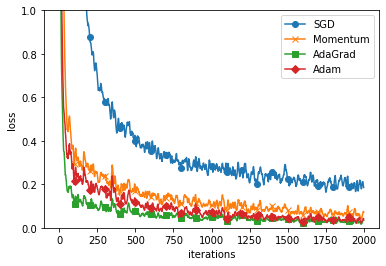

In [6]:
# 3. 그래프 그리기==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

## 6.2 가중치의 초깃값

### 6.2.1 초깃값을 0으로 하면?